# 最尤推定

*MLE - Maximum Likelihood Estimation*

得られたデータ$x$に対して、パラメータ$\theta$に従う何らかの分布$p(x;\theta)$を仮定し、その下での尤度$p(x;\theta)$を最大化するパラメータ$\theta$を求める。

$$
\hat\theta = \argmax_{\theta}\,p(x;\theta)
$$

最尤推定によって、「その分布から$x$が得られることが尤もらしい」と言えるような分布が得られる。  
そのような分布は$x$の裏に存在する真の分布の近似として適していると言える。

In [20]:
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import torch

例えば、以下のようなデータが得られたとする。

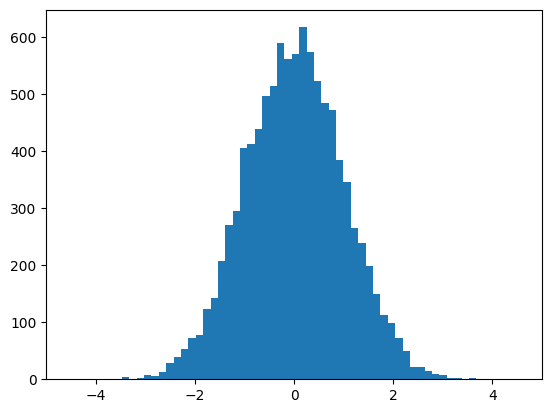

In [21]:
mu, sigma = 0, 1
X = dist.Normal(mu, sigma).sample((10000,))
plt.hist(X, bins=50)
plt.xlim(-5, 5);

このデータに対して、適当に用意した二つの分布$p_1(x), p_2(x)$を当てる。

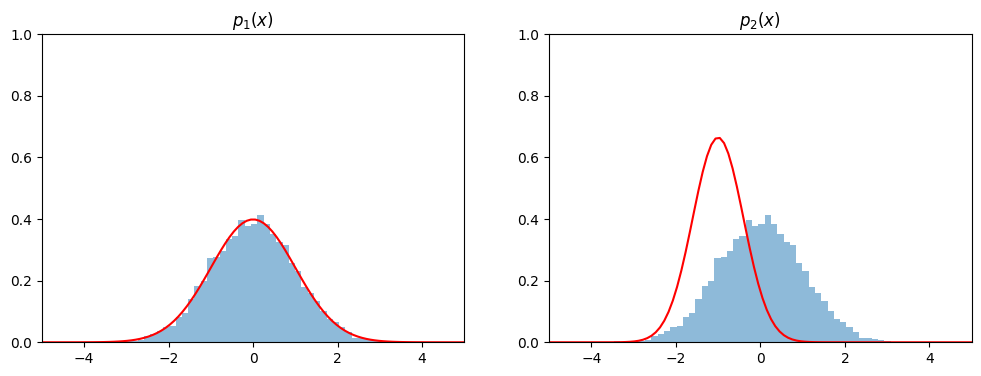

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
x = np.linspace(-5, 5, 100)
mu1, sigma1 = 0, 1
mu2, sigma2 = -1, 0.6
p = [
    stats.norm.pdf(x, loc=mu1, scale=sigma1),
    stats.norm.pdf(x, loc=mu2, scale=sigma2),
]

for i, ax in enumerate(axes):
    ax.hist(X, bins=50, density=True, alpha=0.5)
    ax.plot(x, p[i], "r")
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 1)
    ax.set_title(f"$p_{i+1}(x)$")

どちらの方が適しているでしょう？と問われれば、大体の人は$p_1(x)$を選ぶでしょう。  
なんか適合している感あるからね。

実際に二つの分布での$x$の尤度を比較してみよう。  
尤度だとめちゃくちゃ小さな値になってしまうので、対数尤度を比較する。

In [51]:
ll1 = stats.norm.logpdf(X, loc=mu1, scale=sigma1).sum()
ll2 = stats.norm.logpdf(X, loc=mu2, scale=sigma2).sum()
print(f'対数尤度 p1: {ll1}')
print(f'対数尤度 p2: {ll2}')

対数尤度 p1: -14129.57291737977
対数尤度 p2: -31917.7590071355


$p_1(x)$の方が尤度が高くなった。ということで、"得られたデータに対して適切な確率分布を得るために尤度が最も大きくなる分布を求める"事が妥当であると考えられる。

### 手順

最尤推定は以下の手順で行う。

1. 得られたデータの分布として適切なものを選ぶ
2. 分布のパラメータを推定する

この手順は最尤推定に限らず多くの手法に共通している。


---

## 確率分布の選定

1つ目の手順。

データの性質をよく考え、観察し、いくつかの主要な分布の中から適切なものを仮定する。  
この過程は問題を数学的に記述するステップともいえる。

実際に例題を見ながら適切な確率分布を選んでみよう。

### 例題1

参考
- [最尤推定量とは？初めての人にもわかる解説 | AVILEN AI Trend](https://ai-trend.jp/basic-study/estimator/maximum-likelihood-estimation/)

> ある箱の中に10個の玉がある。玉の色は赤か白のいずれかである。  
> 箱の中からランダムに玉を取り出し、色を確認してから戻す。これを10回繰り返した。  
> その結果、赤玉が3回、白玉が7回出てきた。さあ、箱の中には赤玉が何個あるだろうか。

箱の中身を直接覗くのはナシ。正解は分からないので、一番確率の高い個数を求める問題となる。  
直感的に、問いの答えを3個だと感じる人は多いだろう。実際にそれは正しいが、ここでは知らないフリをする。

では適切な確率分布を選ぼう。

まず確率変数を定義する。今回は、箱の中からランダムに取り出した玉の色を確率変数$x$としよう。赤玉を$x=1$、白玉を$x=0$とする。  
次に確率分布を定義する訳だが、結果が2通りしかない場合はベルヌーイ分布が当てはまるので、今回もそれにする。

以上で確率変数と確率分布が定義できた。この下で、尤度が最大となるパラメータを求める。  
求めるパラメータを$\theta$としよう。$\theta$はベルヌーイ分布のパラメータを指し、それは$x$が1となる確率=箱の中の赤玉の割合を意味する。適切な$\theta$が求められれば、その$\theta$と箱の中の玉の個数をかけることで、赤玉の個数が推定できる。

では次のステップへ、と行きたいところだが、これらの仮定は少しだけ簡略化することが出来る。

実は、成功（1が出る）確率$\theta$のベルヌーイ試行を$n$回行ったときの成功回数（=1が出た回数）を$x$とするとき、$x$が従う確率分布として二項分布がある。  
二項分布は以下。

$$
\mathrm{bin}(x;n,\theta) = {}_n C_x \theta^x (1-\theta)^{n-x}
$$

得られた全サンプルに対してベルヌーイ分布の尤度を求め、その積が最大となる$\theta$を求めてもよいが、せっかく二項分布という便利な確率分布があるので、これを使う。

二項分布の試行回数$n=10$、赤玉が出る確率$\theta$の下で、赤玉が$x=3$回出る確率が最も大きくなる様な$\theta$を求める。

### 例題2

> 標本$X$が得られた。$X$のヒストグラムは以下のようになった。$X$の分布を推定せよ。

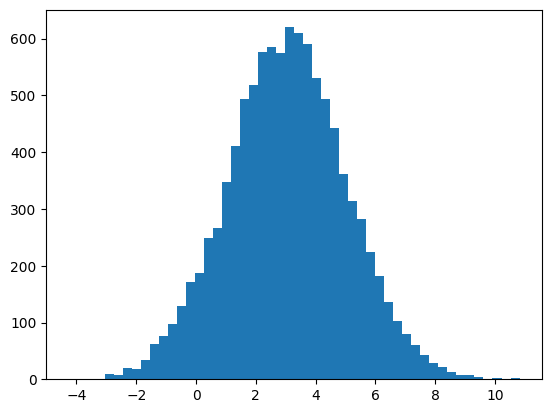

In [2]:
mu, sigma = 3, 2 # 平均3, 標準偏差2（分散4）
x = dist.Normal(mu, sigma).sample((10000,))
plt.hist(x, bins=50);

標本が得られた場合は分布を観察して良くフィットする確率分布を選ぶ。今回の場合、ある地点とその付近が最も多く、そこから離れるにつれて対照的に少なくなっていることから、正規分布が適していると考えられる。  
得られた標本から正規分布のパラメータである平均と分散を推定する問題へ落とし込めた。

この例題についても、直感的に解を求めることができる。標本から平均と分散求めればよくね？という話。まあ、これも実際正しい。ただしそれが正しいことをしっかり証明する必要はあり、それを以下で示す。


---

## パラメータ推定

では、先程の例題を引き継いで、パラメータの推定まで行ってみよう。

### 総当たりで求める

取りうる全ての値を試して最大値を求める。

例題1を使う。

まずパラメータ$\theta$の下でのデータ$x$の尤度を記述する尤度関数を定義する。

$$
\begin{align}
L(\theta)
    &= p(x|\theta) \\
    &= \mathrm{Bin}(x;n,\theta) \\
    &= {}_n C_x p^x (1-p)^{n-x}
\end{align}
$$

求めたいパラメータ（二項分布の確率）は$\theta$とした。なお$n=10$は確定している。  
このとき、求めたいものは以下のように記述される。

$$
\hat\theta = \arg\max_\theta L(\theta)
$$

この$\theta$に、$\theta$がとりうるすべての値を代入して解を求める。

玉の個数は10個なので、その中の赤玉の割合を表す$\theta$には以下の値が入る。

In [54]:
theta = torch.arange(1, 10) / 10
theta

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000])

（試行により赤玉と白玉が1つ以上入っている事が確定しているので$0.1\leq\theta\leq0.9$）

これら一つ一つで尤度を計算して、最大値を取った$\theta$を求めるだけ。

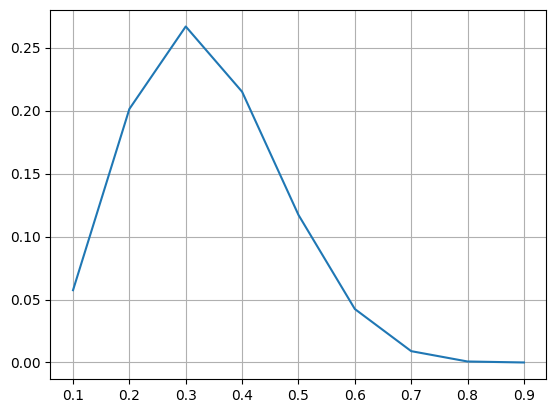

In [55]:
x = torch.tensor(3) # 実測値
n = 10 # 試行回数

binomal = dist.Binomial(n, theta) # 試行回数10, 確率thetaの二項分布
probs = binomal.log_prob(x).exp() # 分布から3が得られる確率
plt.plot(theta, probs)
plt.xticks(theta)
plt.grid();

$\theta = 0.3$が最も大きくなった。正解！これは**最尤推定量**と呼ぶ。  
以上より、箱の中には赤玉が$\theta\times10=3$個あると推定できる。

### 解析的に求める

先ほどは$\theta$が離散値で且つ選択肢も少なかったので総当たりで求められたが、選択肢が多い場合やそもそも連続値の場合、総当たりには限界がある。  
そこで、解析的に求める手法を考える。

やり方は簡単で、尤度関数を$\theta$について微分して、傾きが0になる$\theta$を求めるだけ。  
この時の尤度は正確には極大（小）値であるが、大体の場合は最大値を表している。最大値を表さない場合はこの手法を使えないかな？

またほとんどの場合、普通の尤度関数ではなく対数をとった**対数尤度関数**を考える。この方が計算しやすいから。$\log(x)$は単調増加関数で$\argmax_{\theta} p(X|\theta) = \argmax_{\theta} \log p(X|\theta)$が成り立つため、置き換えることが可能。

ではやってみよう。今度は例題2を使う。

まず対数尤度関数を定義する。

$$
\begin{align}
\log L(\theta)
&= \log p(X;\theta) \\
&= \log \prod_{i=1}^n p(x_i;\theta) \\
&= \sum_{i=1}^n \log p(x_i;\theta) \\
&= \sum_{i=1}^n \log \mathcal N(x_i;\mu,\sigma) \\
&= \sum_{i=1}^n \log \left( \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(x_i-\mu)^2}{2\sigma^2} \right) \right) \\
&= \sum_{i=1}^n \left( \log \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right) + \log \left( \exp \left( -\frac{(x_i-\mu)^2}{2\sigma^2} \right) \right) \right) \\
&= \sum_{i=1}^n \left( -\frac{1}{2}\log(2\pi) - \log\sigma - \frac{(x_i-\mu)}{2\sigma^2} \right)
\end{align}
$$

$\theta$は$\mu,\sigma^2$のこと。複数のパラメータをまとめて$\theta$と表すことはよくある。  
そしてこんな風に、対数にすると積を和にできる。これは微分をする上でとってもありがたいこと。このために対数尤度関数を使う。

ではここから、各パラメータ（$\mu,\sigma^2$）で微分していく

まずは$\mu$から。

$$
\begin{align}
\frac{\partial}{\partial\mu}\log L
&= \frac{\partial}{\partial\mu} \sum_{i=1}^n -\frac{(x_i-\mu)^2}{2\sigma^2} \\
&= \sum_{i=1}^n \frac{x_i-\mu}{\sigma^2}
\end{align}
$$

これが0になる$\mu$を求める。

$$
\begin{align}
\sum_{i=1}^n \frac{x_i-\mu}{\sigma^2} &= 0 \\
(x_1-\mu) + (x_2-\mu) + \cdots + (x_n-\mu) &= 0 \\
(x_1 + x_2 + \cdots + x_n) - n\mu &= 0 \\
\frac{(x_1 + x_2 + \cdots + x_n)}{n} &= \mu
\end{align}
$$

ということで、無事標本$X$の平均値になった。

では、今度は$\sigma^2$を求めていく。

$$
\begin{align}
\frac{\partial}{\partial\sigma}\log L &= -\sum_{i=1}^n \left( \frac{\partial}{\partial\sigma} \log\sigma + \frac{\partial}{\partial\sigma} \frac{(x_i-\mu)^2}{2\sigma^2} \right) \\
&= -\sum_{i=1}^n \left( \frac{1}{\sigma} - \frac{(x_i-\mu)^2}{\sigma^3} \right) \\
&= -\sum_{i=1}^n \left( \frac{\sigma^2 - (x_i-\mu)^2}{\sigma^3} \right)
\end{align}
$$

これが0になる$\sigma^2$を求める。

$$
\begin{align}
-\sum_{i=1}^n \left( \frac{\sigma^2 - (x_i-\mu)^2}{\sigma^3} \right) &= 0 \\
\sum_{i=1}^n (x_i-\mu)^2 &= n\sigma^2 \\
\frac{\sum_{i=1}^n (x_i-\mu)^2}{n} &= \sigma^2 \\
\end{align}
$$

ということで、無事標本$X$の分散になった。

例題1でもやってみよう

求め方はさっきと一緒で、対数尤度関数を微分して0になるパラメータを求める。

では求めていこう、の前に、この問題は1つのパラメータを求める問題なので、尤度関数を可視化できる。せっかくなので見てみよう。

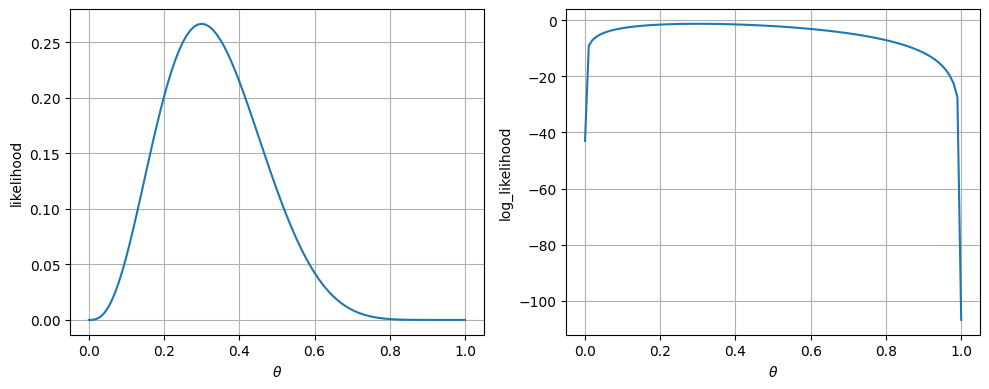

In [5]:
x = torch.tensor(3) # 実測値

p = torch.arange(0, 1 + 0.01, 0.01)
binomal = dist.Binomial(10, p)
log_likelihood = binomal.log_prob(x) # 対数尤度
likelihood = log_likelihood.exp() # 尤度
plt.figure(figsize=(10, 4))
for i, name in enumerate(['likelihood', 'log_likelihood']):
    plt.subplot(1, 2, i+1)
    plt.plot(p, eval(name))
    plt.xlabel(r'$\theta$')
    plt.ylabel(name)
    plt.grid()
plt.tight_layout();

ちゃんと上に凸な形になっていて、傾きが0になる唯一の$\theta$が最大値となっている。

では求めていこう。まずは対数尤度関数を変形する。

$$
\begin{align}
    \mathrm{log} \, L(\theta|x)
        &= \mathrm{log} \, \left( {}_n C_x \theta^x (1-\theta)^{n-x} \right) \\
        &= \mathrm{log} \, {}_n C_x + x \mathrm{log} \, \theta + (n-x) \mathrm{log} \, (1-\theta) \\ 
\end{align}
$$

次にこれを$\theta$で微分する

$$
\begin{align}
    \frac{\partial}{\partial\theta} \mathrm{log}L
        &= 0 + \frac{x}{\theta} - \frac{n-x}{1-\theta} \\
        &= \frac{x(1-\theta) - (n-x)\theta}{\theta(1-\theta)} \\
        &= \frac{x - \theta n}{\theta(1-\theta)} \\
\end{align}
$$

でこれが0になる$\theta$を求める

$$
\begin{align}
    \frac{x - \theta n}{\theta(1-\theta)} &= 0 \\
    x - \theta n &= 0 \\
    \theta n &= x \\
    \theta &= \frac{x}{n} \\
\end{align}
$$

できた。  
$n=10, x=3$より、$\theta = \frac{3}{10} = 0.3$が最尤推定量となる。